<a href="https://colab.research.google.com/github/87tana/YOLOv8-Bone-Fracture-Detection-Model/blob/main/EDA_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

in this notebook, i assess the label distribution, bounding box statistic, image dimension and data quality

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/'


# Define dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection


In [2]:
# Install necessary libraries
!pip install -q ultralytics torch torchvision opencv-python pillow matplotlib tqdm
!pip install tabulate


In [3]:
# Import required libraries
import os
import random
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import cv2

import matplotlib.pyplot as plt
from IPython.display import display

from ultralytics import YOLO

In [4]:
# Set dataset paths
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

In [5]:
#----------------------------------------------------------------------Train Dataset----------------------------------------------------------------

# list comprehensions to create a list for storing train images and labels respectively
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(train_image_files) != len(train_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Train Dataset is consistent.")

# Quick summary of train set
print(f"Number of train images: {len(train_image_files)}")
print(f"Number of train labels: {len(train_label_files)}")

Train Dataset is consistent.
Number of train images: 3779
Number of train labels: 3779


In [6]:
# ---------------------------------------------------------------------Valid Dataset----------------------------------------------------------------------------
# list comprehensions to create a list for storing valid images and labels respectively
validation_image_files = sorted([f for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_label_files = sorted([f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(validation_image_files) != len(validation_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Validation Dataset is consistent.")

# Quick summary of train set
print(f"Number of validation images: {len(validation_image_files)}")
print(f"Number of validation labels: {len(validation_label_files)}")

Validation Dataset is consistent.
Number of validation images: 835
Number of validation labels: 835


In [7]:
#----------------------------------------------------------------------- Test Dataset-----------------------------------------------------------------------------

# list comprehensions to create a list for storing valid images and labels respectively
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(('.jpg','.png'))])
test_label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(test_image_files) != len(test_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("test Dataset is consistent.")

# Quick summary of train set
print(f"Number of test images: {len(test_image_files)}")
print(f"Number of test labels: {len(test_label_files)}")

test Dataset is consistent.
Number of test images: 841
Number of test labels: 841


#  Parse Annotations and Prepare Data

In [8]:
def parse_annotations(labels_dir, images_dir):
    """
    Extracts: file name, image(W,H), bbx(W,H), # of bbx
    Input: label_dir and image_dir
    Output: A list of dictionaries, each containing details about an image and its bounding boxes.
    """

    data = []

    for label_file in os.listdir(labels_dir):  # Iterate over annotation files
        label_path = os.path.join(labels_dir, label_file)
        image_path = os.path.join(images_dir, label_file.replace('.txt', '.jpg'))  # Get corresponding image

        # Get image dimensions
        img = cv2.imread(image_path)
        if img is None:
            continue  # Skip if image is missing
        img_height, img_width = img.shape[:2]

        # Parse label file and extract bounding box information
        bbox_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                _, x_center, y_center, width, height = map(float, line.strip().split())  # Ignore class ID
                # Convert relative dimensions to absolute pixels
                bbox_width = width * img_width
                bbox_height = height * img_height
                data.append({
                    "file_name": label_file,
                    "img_width": img_width,
                    "img_height": img_height,
                    "bbox_width": bbox_width,
                    "bbox_height": bbox_height
                })
                bbox_count += 1

        # Handle images with zero bounding boxes
        if bbox_count == 0:
            data.append({
                "file_name": label_file,
                "img_width": img_width,
                "img_height": img_height,
                "bbox_width": 0,
                "bbox_height": 0,
                "num_bboxes": 0
            })
        else:
            # Update the last entry with the number of bounding boxes
            data[-bbox_count]["num_bboxes"] = bbox_count

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [9]:
validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

val_data = parse_annotations(validation_labels_dir,validation_images_dir )

In [10]:
# Display the DataFrame in a styled table format
display(val_data.head())

,file_name,img_width,img_height,bbox_width,bbox_height,num_bboxes
0,images238_jpg.rf.e42be5127b183e6b62164f7f77022...,640,640,171.5,258.0,2.0
1,images238_jpg.rf.e42be5127b183e6b62164f7f77022...,640,640,271.5,156.5,NaN
2,image2-17-_png.rf.f742020551425cb898e3eca29189...,640,640,640.0,620.0,1.0
3,image6_jpeg.rf.960a40c662df8be1faedb85435ddf5e...,640,640,71.5,145.5,1.0
4,image1-9-_png.rf.354c74a733a852c18c729641847b8...,640,640,474.0,608.0,1.0


In [11]:
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

train_data = parse_annotations(train_labels_dir,train_images_dir )

In [12]:
# Display the DataFrame in a styled table format
display(train_data.head())

,file_name,img_width,img_height,bbox_width,bbox_height,num_bboxes
0,negative_692_jpg.rf.a56e374ec0a5ad9c0d39b5131a...,640,640,560.0,563.5,1.0
1,negative_68_jpg.rf.289cf266e9498c027e9728054ec...,640,640,396.0,607.0,1.0
2,negative_6_jpg.rf.65869a8e56bf27532b51cfd0cfff...,640,640,584.0,541.0,1.0
3,negative_686_jpg.rf.b88f5bebce6e13d797b6c91650...,640,640,640.0,640.0,1.0
4,negative_688_jpg.rf.78356b403a4ed1efd5442b0b81...,640,640,330.0,577.5,1.0


In [13]:
test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

test_data = parse_annotations(test_labels_dir,test_images_dir )

In [14]:
# Display the DataFrame in a styled table format
display(test_data.head())

,file_name,img_width,img_height,bbox_width,bbox_height,num_bboxes
0,forearmpeds1_jpg.rf.5ece0d91646b1289554500c6ee...,640,640,74.5,130.5,3.0
1,forearmpeds1_jpg.rf.5ece0d91646b1289554500c6ee...,640,640,53.5,100.5,NaN
2,forearmpeds1_jpg.rf.5ece0d91646b1289554500c6ee...,640,640,101.0,210.0,NaN
3,image1-71-_png.rf.0fab732eb5d8c600e0d31fc9d38b...,640,640,212.0,452.0,1.0
4,image2-10-_png.rf.8cc9dd4467a54e95dc81858c06b7...,640,640,183.0,327.0,1.0


we want to do this 4 steps:

Extract Data: We'll extract bounding box sizes (width, height), image sizes, and calculate the diagonal.

Plot Histograms: First, we'll create histograms for the width and height for all subsets separately (train, validation, test).
Plot Diagonal Length: Then we'll plot histograms for the diagonal length for all subsets separately.
Clustering: Finally, we'll perform clustering on the bounding box sizes and visualize the clusters.

# Helper Function for Extracting Data for Plotting (Width, Height, Diagonal)

In [15]:
def calculate_diagonal(width, height):
    """
    Calculate the diagonal length of a bounding box.
    """
    return np.sqrt(width**2 + height**2)

def extract_data_for_plotting(data):
    """
    Extracts bounding box widths, heights, and diagonal lengths.
    Args:
    - data: DataFrame containing bounding box and image information

    Returns:
    - widths: List of bounding box widths
    - heights: List of bounding box heights
    - diagonals: List of bounding box diagonal lengths
    """
    widths = []
    heights = []
    diagonals = []

    for _, entry in data.iterrows():
        bbox_width = entry["bbox_width"]
        bbox_height = entry["bbox_height"]

        # Append width and height to their respective lists
        widths.append(bbox_width)
        heights.append(bbox_height)

        # Calculate diagonal and append to diagonals list
        diagonal = calculate_diagonal(bbox_width, bbox_height)
        diagonals.append(diagonal)

    return widths, heights, diagonals



# Plotting Histograms for Width/Height Ratios and Diagonal Lengths

# Plot Histogram for diagonal length

In [19]:
import matplotlib.pyplot as plt

# Function to plot histograms for width and height
def plot_width_height_histograms(train_data, val_data, test_data):
    """
    Plots histograms for bounding box width and height for train, validation, and test data.
    """
    # Extract data for width, height
    train_widths, train_heights, _ = extract_data_for_plotting(train_data)
    val_widths, val_heights, _ = extract_data_for_plotting(val_data)
    test_widths, test_heights, _ = extract_data_for_plotting(test_data)

    # Plot width histogram for all subsets
    plt.figure(figsize=(8, 4))
    plt.hist([train_widths, val_widths, test_widths], bins=10, label=["Train", "Validation", "Test"], alpha=0.7)
    plt.title('Bounding Box Widths for All Subsets')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Plot height histogram for all subsets
    plt.figure(figsize=(8, 4))
    plt.hist([train_heights, val_heights, test_heights], bins=10, label=["Train", "Validation", "Test"], alpha=0.7)
    plt.title('Bounding Box Heights for All Subsets')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Function to plot diagonal length histogram
def plot_diagonal_histograms(train_data, val_data, test_data):
    """
    Plots histograms for bounding box diagonal lengths for train, validation, and test data.
    """
    # Extract diagonal lengths for all subsets
    _, _, train_diagonals = extract_data_for_plotting(train_data)
    _, _, val_diagonals = extract_data_for_plotting(val_data)
    _, _, test_diagonals = extract_data_for_plotting(test_data)

    # Plot diagonal length histogram for all subsets
    plt.figure(figsize=(8, 4))
    plt.hist([train_diagonals, val_diagonals, test_diagonals], bins=10, label=["Train", "Validation", "Test"], alpha=0.7)
    plt.title('Diagonal Lengths for All Subsets')
    plt.xlabel('Diagonal Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# KMeans Clustering on Bounding Box Sizes (Width, Height)

In [17]:
from sklearn.cluster import KMeans

def plot_bounding_box_clustering(train_data, val_data, test_data):
    """
    Perform KMeans clustering on bounding box sizes (width, height) and plot the results.
    """
    # Extract widths and heights for clustering
    train_widths, train_heights, _ = extract_data_for_plotting(train_data)
    val_widths, val_heights, _ = extract_data_for_plotting(val_data)
    test_widths, test_heights, _ = extract_data_for_plotting(test_data)

    # Combine all data for clustering
    all_widths = train_widths + val_widths + test_widths
    all_heights = train_heights + val_heights + test_heights

    # Reshape data for clustering (features: width, height)
    data_for_clustering = np.array(list(zip(all_widths, all_heights)))

    # Perform KMeans clustering (adjust n_clusters as needed)
    kmeans = KMeans(n_clusters=9, random_state=42)
    kmeans.fit(data_for_clustering)

    # Plot clustering results
    plt.figure(figsize=(8, 6))
    plt.scatter(all_widths, all_heights, c=kmeans.labels_, cmap='viridis', alpha=0.7)
    plt.title('Clustering of Bounding Box Sizes')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.colorbar(label='Cluster')
    plt.show()


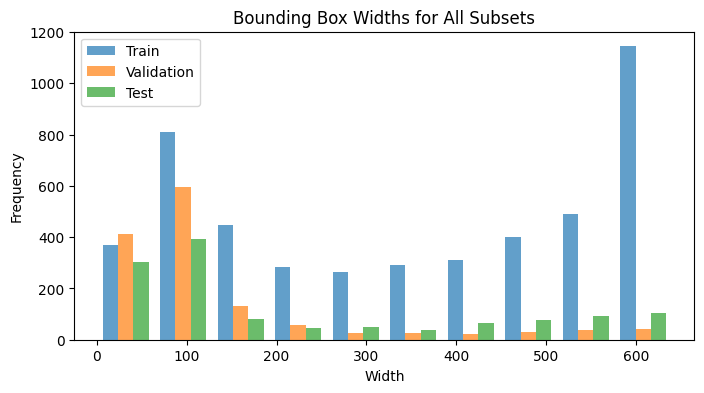

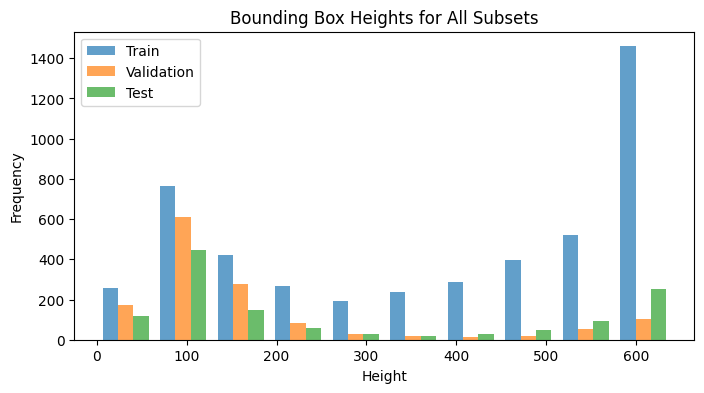

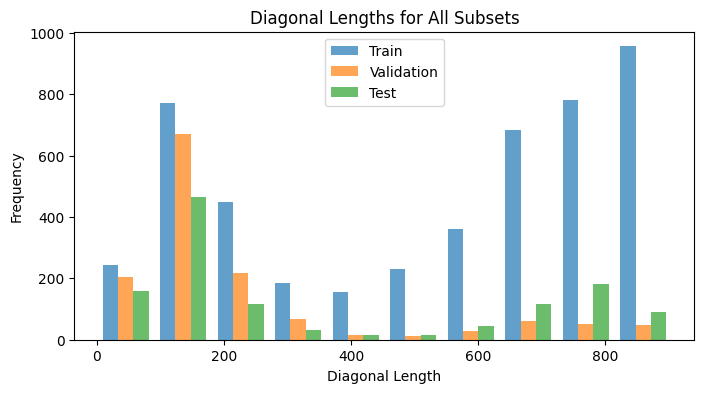

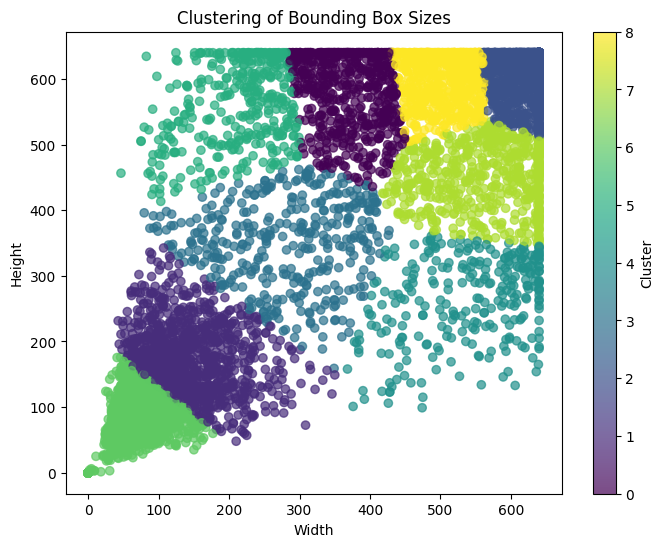

In [20]:
# Plot width and height histograms for all subsets (train, val, test)
plot_width_height_histograms(train_data, val_data, test_data)

# Plot diagonal length histograms for all subsets (train, val, test)
plot_diagonal_histograms(train_data, val_data, test_data)

# Perform clustering on bounding box sizes (width, height) for all subsets (train, val, test)
plot_bounding_box_clustering(train_data, val_data, test_data)
